## Problem 3: 

#### Produce random points following $h(x) \sim \exp(-x/3)\cos(x)^2$ in the interval $[0, \infty]$ and estimate the integral of $h(x)$ in the defined range.

*Solution Example to Problem 3*:<br>

This is a harder problem than the two above. The function can neither be integrated and then inverted nor bounded in $x$. Therefore, one has to combine the two methods. First, we want to generate numbers according to __"a smart box"__, i.e. with a function that covers $h(x)$, i.e. is always greater than $h(x)$ and can be produced using the transformation method. In our case, the exponential function $k(x) = 1/3 \exp(-x/3)$ serves the purpose very well.

We thus draw $x$-values from $k(x)$ (transformation method) and accept the $x$-value if a random value $y$ (chosen between 0 and $k(x)$ falls below the functional value of $h(x)$ at the chosen $x$-value (accept/reject).

In [61]:
import random
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm ,gamma           # Functions from SciPy Stats...
# import scipy.optimize as optimization
from scipy import optimize
from numpy.linalg import inv
from functools import partial
from fitter import Fitter
from astropy.modeling import models, fitting

In [62]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [63]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000    # Number  

In [64]:
x_exp1 = -0.8*np.log(r.uniform(size=N_points))
x_exp2 = -0.8*np.log(r.uniform(size=N_points))
x_exp3 = -0.8*np.log(r.uniform(size=N_points))
x_exp4 = -0.8*np.log(r.uniform(size=N_points))
x_expsum = x_exp1 + x_exp2 + x_exp3 + x_exp4

0.2


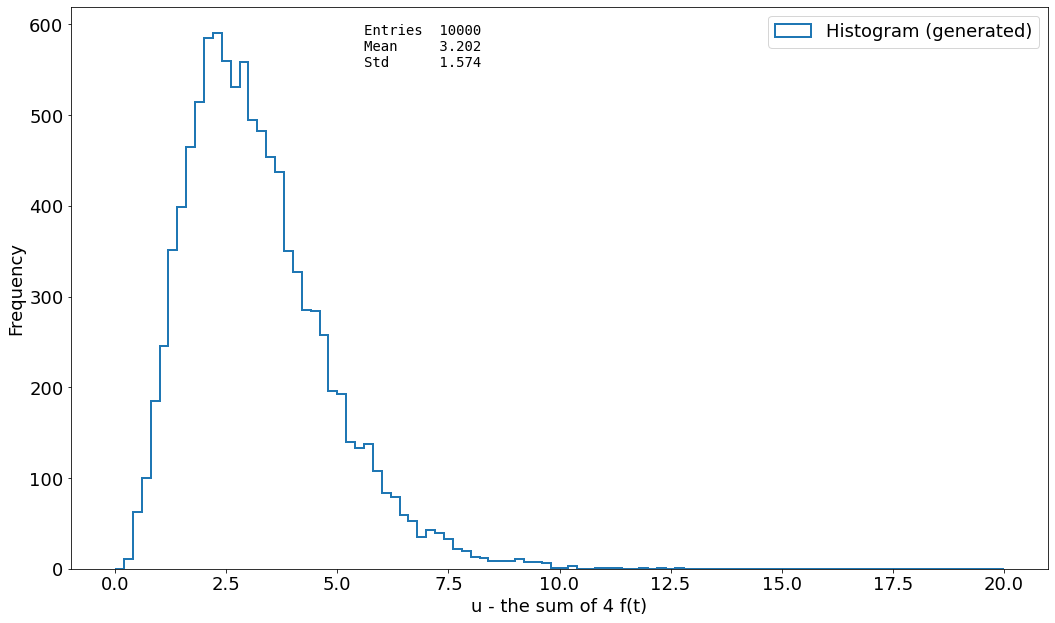

In [65]:

# f(x)
def exp_func(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / Nbins
    N = N_points * k
    return N * 1/0.8 * np.exp(-x/0.8)

# Define a reasonable range to plot in:
xmin = 0
xmax = 20
Nbins = 100
binwidth = (xmax - xmin) / Nbins
print(binwidth)


# plot sum
fig, ax = plt.subplots(figsize=(15, 9))
ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2,label='Histogram (generated)' )
ax.set(xlabel="u - the sum of 4 f(t)", ylabel="Frequency", xlim=(xmin-1.0, xmax+1.0)) # 不知道为什么原来是"Frequency / 0.2"

# Plot f(x)
x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = exp_func(x_axis1)
#ax.plot(x_axis1, y_axis1, 'r-', label='Function (not fitted)')

# Define figure text
d = {'Entries': len(x_expsum),
     'Mean': x_expsum.mean(),
     'Std': x_expsum.std(ddof=1),
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.97, text, ax, fontsize=14)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

# Save figure
fig.savefig("HistAndFunc_exp.png", dpi=600)

In [66]:

# 朴素计算10000个点的mu和sigma
mu = np.sum(x_expsum)/N_points
mu_array = np.ones_like(x_expsum) * mu
a = np.zeros_like(x_expsum)
a_sum = float

for i in range(0,10000):
    a[i] = (x_expsum[i] - mu_array[i])**2
    
a_sum = np.sum(a)
sigma = np.sqrt(a_sum/N_points)
print(mu)
print(sigma)


3.2017026139636466
1.5741536459636298


57 57 57
0.2
10000
[ 0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9
  3.1  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7
  5.9  6.1  6.3  6.5  6.7  6.9  7.1  7.3  7.5  7.7  7.9  8.1  8.3  8.5
  8.7  8.9  9.1  9.3  9.5  9.7  9.9 10.1 10.3 10.9 11.1 11.3 11.9 12.3
 12.7]
[ 11  63 100 185 245 351 399 465 514 585 590 560 531 559 495 482 454 437
 350 327 285 284 258 196 193 140 133 137 108  84  79  59  53  35  43  40
  33  22  20  13  12   9   9   9  11   8   7   6   1   1   3   1   1   1
   1   1   1]


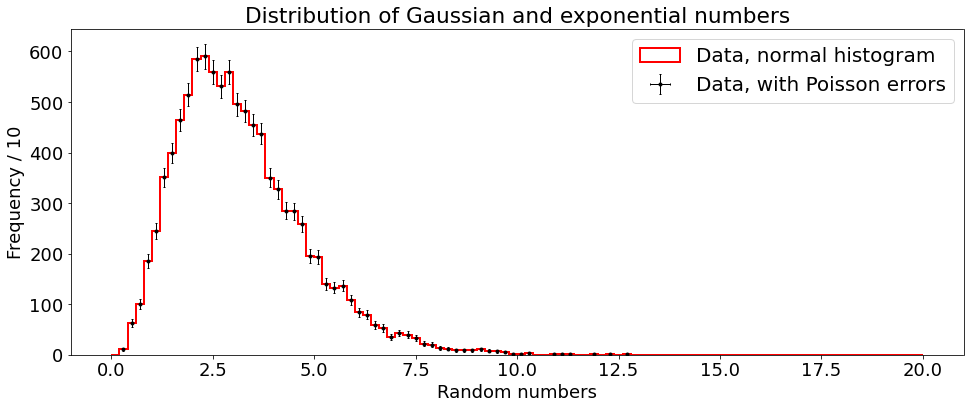

In [67]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_expsum, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0]+ bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts)[counts>0]  # NOTE: We (naturally) assume that the bin count is Poisson distributed. 不能为0
# 分母不能为0 如果有必要，可以添加：[counts>0]
# This is an approximation, since there is a low count in the last bins.
print(x.size,y.size,sy.size)

# 去除空箱之后重新定义范围
xmin = 0
xmax = 20
Nbins = 100
binwidth = (xmax - xmin) / Nbins
print(binwidth)


hist = ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Data, normal histogram')

ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers",           # the label of the y axis
       ylabel="Frequency / 10",           # the label of the y axis
       title="Distribution of Gaussian and exponential numbers")    # the title of the plot
ax.legend(loc='best', fontsize=20);       # could also be # loc = 'upper right' e.g.
print(np.sum(y))
print(x)
print(y)

In [68]:
print(y)
def fit_function(x,mu,sigma):  #
    return 2000 * (1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2))
mu1,sigma1 = optimize.curve_fit(fit_function,x,y)[0]  # 最小二乘法拟合
x1 = x
print(x1)
print(x)


y1 = np.zeros_like(x1)
for i in range(0,57):
    y1[i] = 2000 *  (1 / np.sqrt(2 * np.pi) / sigma1 * np.exp(-(x[i] - mu1) ** 2 / 2. / sigma1 ** 2))  # x1,y1是拟合值，x,y是观察值

print(y1)
print(y)
print(mu1,sigma1)

[ 11  63 100 185 245 351 399 465 514 585 590 560 531 559 495 482 454 437
 350 327 285 284 258 196 193 140 133 137 108  84  79  59  53  35  43  40
  33  22  20  13  12   9   9   9  11   8   7   6   1   1   3   1   1   1
   1   1   1]
[ 0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9
  3.1  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7
  5.9  6.1  6.3  6.5  6.7  6.9  7.1  7.3  7.5  7.7  7.9  8.1  8.3  8.5
  8.7  8.9  9.1  9.3  9.5  9.7  9.9 10.1 10.3 10.9 11.1 11.3 11.9 12.3
 12.7]
[ 0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9
  3.1  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7
  5.9  6.1  6.3  6.5  6.7  6.9  7.1  7.3  7.5  7.7  7.9  8.1  8.3  8.5
  8.7  8.9  9.1  9.3  9.5  9.7  9.9 10.1 10.3 10.9 11.1 11.3 11.9 12.3
 12.7]
[1.21747292e+02 1.53878145e+02 1.90722572e+02 2.31811391e+02
 2.76296239e+02 3.22940636e+02 3.70150161e+02 4.16045388e+02
 4.58575666e+02 4.95665648e+02 5.25380755e+02 5.46093520e+02
 5

In [69]:
'''
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
hist = ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=0,  label='Data, normal histogram')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poission erros', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
# 绘制gamma分布曲线
  # "α=1,β=2"
ax.plot(x, stats.gamma.pdf(x, fit_alpha, scale=fit_beta), '-r', linewidth=2, label='Chi2 fit model result')

plt.show()
'''

'\nfig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches\nhist = ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype=\'step\', linewidth=0,  label=\'Data, normal histogram\')\nax.errorbar(x, y, yerr=sy, xerr=0.0, label=\'Data, with Poission erros\', fmt=\'.k\',  ecolor=\'k\', elinewidth=1, capsize=1, capthick=1)\n# 绘制gamma分布曲线\n  # "α=1,β=2"\nax.plot(x, stats.gamma.pdf(x, fit_alpha, scale=fit_beta), \'-r\', linewidth=2, label=\'Chi2 fit model result\')\n\nplt.show()\n'

In [70]:
# 利用公式计算卡方
Npoints = 57  # 5个样本
sum1 = np.zeros_like(x)
chi2 = np.zeros_like(x)
sum2 = float
sigmay = float
ey = float

for i in range(0,57):
    sum1[i] = ((y1[i]-y[i])/sy[i])**2  # sum1是各项(观察值-拟合值)平方的数组

Chi2_fit = np.sum(sum1)  # sum2是sum1各项的和
print(Chi2_fit)

1858.3654275394824


In [71]:
# 求出可能性
Nvar = 2
Ndof_fit = Npoints - Nvar
Prob_fit = stats.chi2.sf(Chi2_fit,Ndof_fit)
print(Prob_fit)

0.0


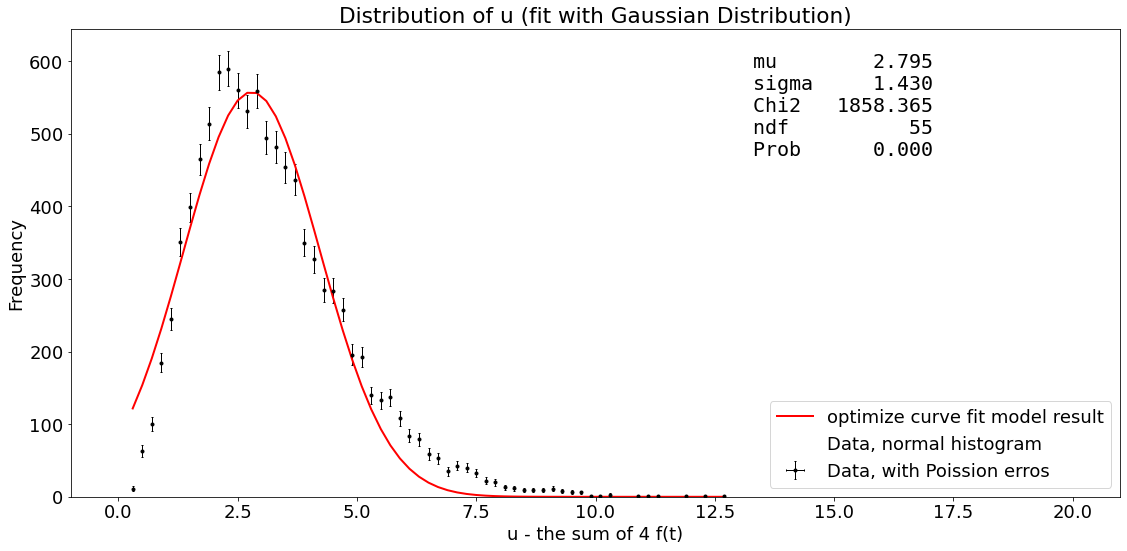

In [84]:

fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
hist = ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=0,  label='Data, normal histogram')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poission erros', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="u - the sum of 4 f(t)", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of u (fit with Gaussian Distribution)", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero


# Adding fit function to plot:
ax.plot(x,fit_function(x=x,mu=mu1,sigma=sigma1), '-r', linewidth=2, label='optimize curve fit model result')   #0.55168


# Adding fit results to plot:

d = {
    'mu': 2.7954762037091823 ,
     'sigma':1.4302269803357377,
 #    'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Chi2':     1858.3654275394824,
     'ndf':      55,
     'Prob':     0.0,
    }
    

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower right', fontsize=18); # could also be # loc = 'upper right' e.g.

fig.tight_layout()
plt.savefig('fig3',dpi=600)
